In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/suicidal-mental-health-dataset/mental-health.csv


In [4]:
import tensorflow as tf
import keras
from keras import layers, optimizers

from keras_hub.tokenizers import WordPieceTokenizer, compute_word_piece_vocabulary

from keras_hub.layers import TokenAndPositionEmbedding, FNetEncoder

import keras_tuner as kt

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('/kaggle/input/suicidal-mental-health-dataset/mental-health.csv')

df['label'] = df['label'].str.replace('SuicideWatch', 'suicidal')
df['label'] = df['label'].str.lower()

binarized = []
for label in df['label']:
    if label == 'suicidal':
        binarized.append(1)
    else:
        binarized.append(0)

binarized = pd.Series(binarized, name='label')
df = df.drop('label', axis=1)
df = pd.concat([df, binarized], axis=1)

In [6]:
train_df, other = train_test_split(
    df,
    test_size = 0.1,
    random_state = 9725,
    shuffle = True,
    stratify = df['label'],
)

val_df, test_df = train_test_split(
    other,
    test_size = 0.5,
    random_state = 9725,
    shuffle = True,
    stratify = other['label'],
)

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_df['text'].values, train_df['label'].values)
)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_df['text'].values, val_df['label'].values)
)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_df['text'].values, test_df['label'].values)
)

In [8]:
# convert the text to lowercase
train_dataset = train_dataset.map(lambda text, label: (tf.strings.lower(text), label))
val_dataset = val_dataset.map(lambda text, label: (tf.strings.lower(text), label))
test_dataset = test_dataset.map(lambda text, label: (tf.strings.lower(text), label))

In [9]:
BATCH_SIZE = 64
MAX_SEQLEN = 512
auto = tf.data.AUTOTUNE

In [10]:
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(auto)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(auto)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(auto)

In [11]:
for text_batch, label_batch in train_dataset.take(1):
    for i in range(3):
        print(f"{text_batch.numpy()[i]}\n{label_batch.numpy()[i]}\n")

b'i miss her so much. we hurt each other but she really fucked me up. smoking a pack a day, eating pills more than food. i am lost and there is no one to find me. what am i looking for? an end. i tried to find it multiple times and it never worked. my entire life has been filled with heartache, death, and all sorts of fucked up shit. i feel like this ends with me. i always told myself my resilience came from carrying my two brothers in my heart so they could live on through my memories. if i die, 3 people die. it will not be a suicide, it will be me killing their memories and myself. i do not even want help, i want to find peace. i miss her so much. i hate that she was the remedy because that was way too much pressure to place on her. i never told her that she was the cure, she knew it i am sure. i hate how we ended things and i cannot reach out to her now even if i wanted. she will never come to look because i am the last thing she wants to see. but as you know annie, i am just a kid 

In [12]:
#Calculate Vocabulary Size
vocabulary = set()
train_df['text'].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

81421


In [13]:
reserved_tokens = ["[PAD]", "[UNK]"]

In [14]:
def train_word_piece(ds, vocab_size, reserved_tokens):
    word_piece_ds = ds.unbatch().map(lambda x, y: x)
    vocab = compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),
        vocabulary_size=vocabulary_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

In [15]:
vocab = train_word_piece(train_dataset, vocabulary_size, reserved_tokens)

In [16]:
print(f'Tokens: {vocab[24:101]}')

Tokens: ['7', '8', '9', ':', ';', '=', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', 'to', 'and', 'my', 'the', 'not', 'am', 'it', 'is', 'of', 'have', 'me', 'do', 'that', 'in', 'but', 'just', 'for', 'this', 'so', 'was', 'with', 'like', 'be', 'want', 'feel', 'you', 'on', 'all', 'life', 'or', 'myself', 'know', 'about']


In [17]:
tokenizer = WordPieceTokenizer(
    vocabulary = vocab,
    lowercase = False,
    sequence_length = MAX_SEQLEN,
)

In [18]:
input_sentence_ex = train_dataset.take(1).get_single_element()[0][0]
input_tokens_ex = tokenizer(input_sentence_ex)

print("Sentence: ", input_sentence_ex)
print("Tokens: ", input_tokens_ex)
print("Recovered text after detokenizing: ", tokenizer.detokenize(input_tokens_ex))

Sentence:  tf.Tensor(b'i miss her so much. we hurt each other but she really fucked me up. smoking a pack a day, eating pills more than food. i am lost and there is no one to find me. what am i looking for? an end. i tried to find it multiple times and it never worked. my entire life has been filled with heartache, death, and all sorts of fucked up shit. i feel like this ends with me. i always told myself my resilience came from carrying my two brothers in my heart so they could live on through my memories. if i die, 3 people die. it will not be a suicide, it will be me killing their memories and myself. i do not even want help, i want to find peace. i miss her so much. i hate that she was the remedy because that was way too much pressure to place on her. i never told her that she was the cure, she knew it i am sure. i hate how we ended things and i cannot reach out to her now even if i wanted. she will never come to look because i am the last thing she wants to see. but as you know an

In [19]:
def format_dataset(sentence, label):
    sentence = tokenizer(sentence)
    return ({"input_ids": sentence}, label)

def make_dataset(dataset):
    dataset = dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(BATCH_SIZE * 8).prefetch(16).cache()

In [20]:
train_dataset = make_dataset(train_dataset)
val_dataset = make_dataset(val_dataset)
test_dataset = make_dataset(test_dataset)

In [21]:
EMBED_DIM = 128
INTERMEDIATE_DIM = 4 * EMBED_DIM

In [32]:
def FentTweaker():
    input_ids = keras.Input(shape=(None,), dtype="int64", name="input_ids")
    x = TokenAndPositionEmbedding(
        vocabulary_size=vocabulary_size,
        sequence_length=MAX_SEQLEN,
        embedding_dim=EMBED_DIM,
        mask_zero=True,
    )(input_ids)
    x = FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
    x = FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
    #x = FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
    
    x = keras.layers.GlobalAveragePooling1D()(x)
    x = keras.layers.Dropout(0.15)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(input_ids, outputs, name="FentTweaker9725")
    model.compile(
        optimizer = optimizers.Adam(
            learning_rate = 1e-4
        ),
        loss = "binary_crossentropy",
        metrics = ["accuracy"]
    )
    return model

In [38]:
FentTweaker9725 = FentTweaker()

In [39]:
FentTweaker9725.summary()

Model: "FentTweaker9725"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding_3       │ (None, None, 128)           │      10,487,424 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_net_encoder_6 (FNetEncoder)        │ (None, None, 128)           │         132,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_net_encoder_7 (FNetEncoder)        │ (None, None, 128)           │         132,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,752,001 (41.02 MB)

 Trainable params: 10,752,001 (41.02 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
reduceLR = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.09725,
    patience = 3,
    verbose = 1,
    mode = "auto",
    min_delta = 1e-4,
    cooldown = 0,
    min_lr = 1e-6,
)

In [42]:
earlyStop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta = 0.001,
    patience = 4,
    verbose = 1,
    mode = "auto",
    restore_best_weights = True,
    start_from_epoch = 10,
)

In [43]:
history = FentTweaker9725.fit(
    train_dataset,
    epochs=25, 
    validation_data=val_dataset,
    callbacks=[earlyStop, reduceLR]
)

Epoch 1/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.5153 - loss: 0.6957 - val_accuracy: 0.5639 - val_loss: 0.6842 - learning_rate: 1.0000e-04
Epoch 2/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.5583 - loss: 0.6823 - val_accuracy: 0.6002 - val_loss: 0.6655 - learning_rate: 1.0000e-04
Epoch 3/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.6315 - loss: 0.6485 - val_accuracy: 0.6798 - val_loss: 0.6054 - learning_rate: 1.0000e-04
Epoch 4/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.6971 - loss: 0.5874 - val_accuracy: 0.6974 - val_loss: 0.5791 - learning_rate: 1.0000e-04
Epoch 5/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.7304 - loss: 0.5450 - val_accuracy: 0.7141 - val_loss: 0.5628 - learning_rate: 1.0000e-04
Epoch 6/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.7609 - loss: 0.5028 - val_accuracy: 0.7299 - val_loss: 0.5488 - learning_rate: 1.0000e-04
Epoch 7/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/ste

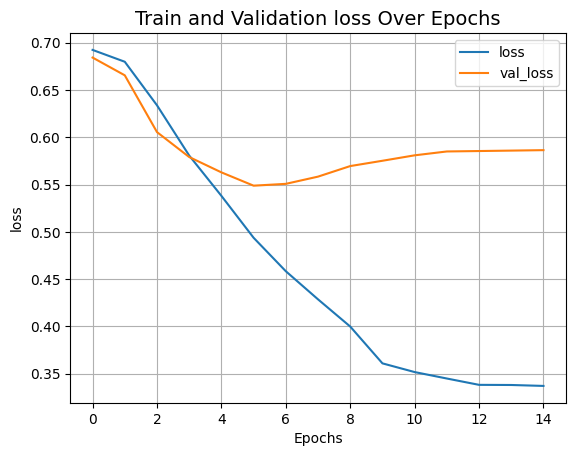

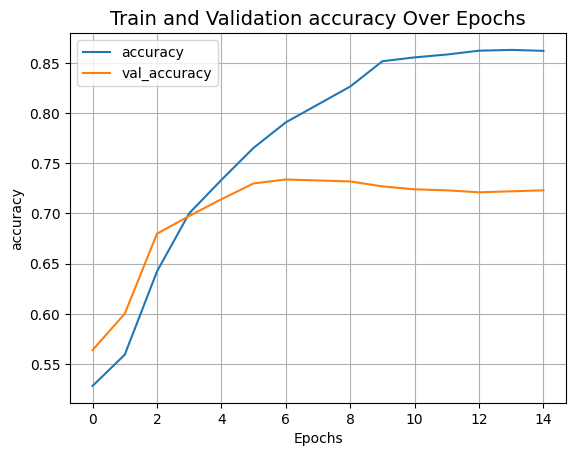

In [44]:
import matplotlib.pyplot as plt

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

In [46]:
FentTweaker9725.evaluate(test_dataset)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.7190 - loss: 0.6134 


[0.5914663672447205, 0.726202130317688]